In [6]:
# Reload and core imports
%reload_ext autoreload
%autoreload 2

# All-in-one imports
import numpy as np
from dolfin import *
from solver import (
    setup_swe_problem, setup_boundary_markers_and_bcs, solve_tidal_flow_velocities
)
from turbines import (
    place_turbines_random, compute_turbine_power, summarize_turbine_power, plot_turbine_layout
)
from plots import plot_velocity_field, compute_power_field_plot
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# PETSc (quiet mode)
from petsc4py import PETSc
PETSc.Options()["ksp_monitor"] = None
PETSc.Options()["ksp_view"] = None


print("✅ Thesis SWE solver ready (v15-12)")

✅ Thesis SWE solver ready (v15-12)


In [9]:
# --- Physical and turbine parameters ---
rho = 1025.0         # Water density [kg/m³]
g = 9.81             # Gravitational acceleration [m/s²]
depth = 50.0         # Water depth [m]

C_T = 0.6             # Turbine thrust coefficient [-]
C_D = 0.0025          # Drag coefficient [-]
sigma = 5.0          # Wake Gaussian spread [m]
D = 5               # Turbine diameter
A_T = np.pi*D**2            # Turbine swept area [m²]

# --- Flow properties ---
U_inflow = 2.0       # Inflow velocity [m/s]
nu_eff = Constant(1.0)  # Effective viscosity [m²/s]
cb = 0.0025    # Bed friction coefficient [-]
viscosity = 1.0 #for now keep turbulent visc or eddy visc

#H = depth  # total depth (assuming flat bottom for now)
nu = viscosity  # viscosity coefficient

# --- Initial conditions ---
initial_condition_u = Constant((0.0, 0.0))
initial_condition_eta = Constant(0.0) # Start with no surface elevation

#----Mesh parameters----
Lx, Ly = 500.0, 400.0
Nx, Ny = 50, 35

n_turbines = 10             # number of turbines
min_spacing = 5*D     # minimum spacing between turbines [m]
#random.seed(42)             # set a fixed seed for reproducibility

#----Showing plots or not----
mesh_plot = True
turbine_position_plot = True


print(f"Initialized base parameters successfully.")

Initialized base parameters successfully.


Success! Initialized u_init with U_inflow = 2.0 m/s on a 50x35 mesh.


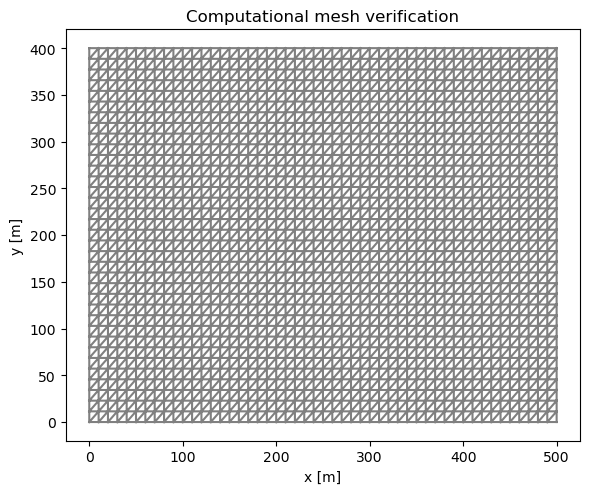

✅ Successfully placed 10 turbines after 11 attempts.
Initialized 10 turbines successfully.


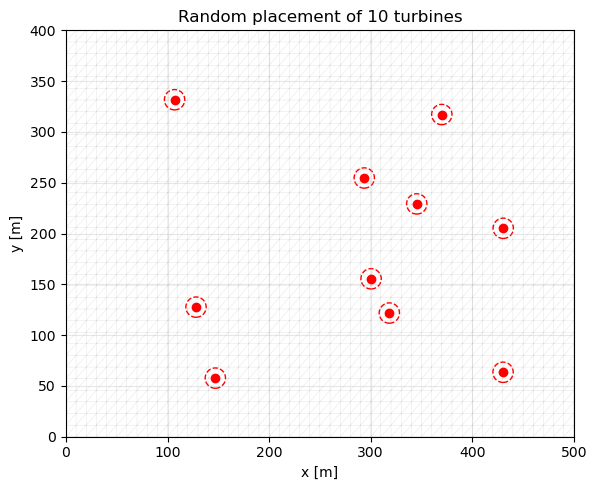

✅ Boundary markers created and BCs applied:
   - Inlet (ID=1): 2.0 m/s
   - Outflow (ID=2): marked for future use


In [10]:
#setting up mesh and initial turbine positions and boundary conditions and markers
mesh, W, w, u, eta, v, q, inflow, outflow, walls = setup_swe_problem(
    Lx, Ly, Nx, Ny, U_inflow, mesh_plot
)

turbine_positions = place_turbines_random(Lx, Ly, n_turbines, sigma, min_spacing)
plot_turbine_layout(mesh, turbine_positions, Lx, Ly, sigma, turbine_position_plot)
boundary_markers, bcs = setup_boundary_markers_and_bcs(mesh, W, Lx, U_inflow)

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.027e+00 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton iteration 1: r (abs) = 5.399e-02 (tol = 1.000e-08) r (rel) = 2.663e-02 (tol = 1.000e-07)
  Newton iteration 2: r (abs) = 5.391e-05 (tol = 1.000e-08) r (rel) = 2.659e-05 (tol = 1.000e-07)
  Newton iteration 3: r (abs) = 1.028e-10 (tol = 1.000e-08) r (rel) = 5.072e-11 (tol = 1.000e-07)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
The total power is 1768.3 kW
Maximum theoretical power per turbine (Betz-adjusted): 135.25 kW
Momentum-sink (raw thrust) power per turbine:          193.21

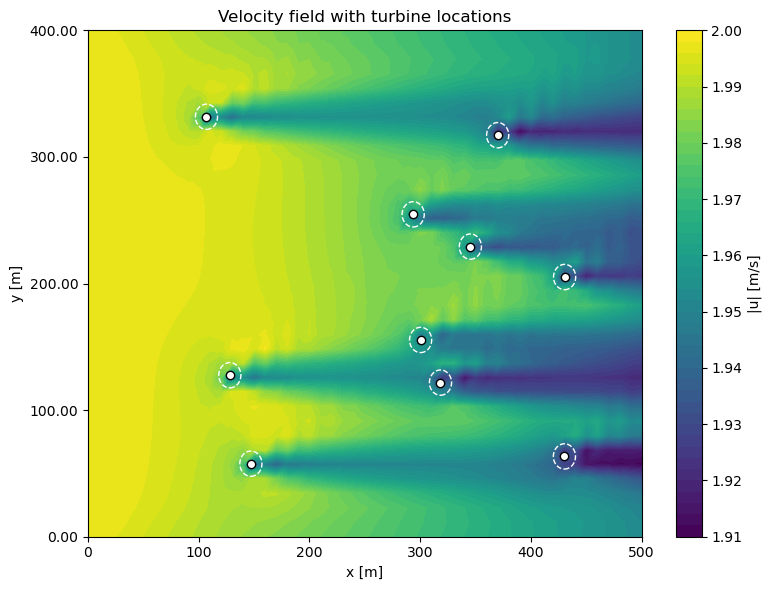

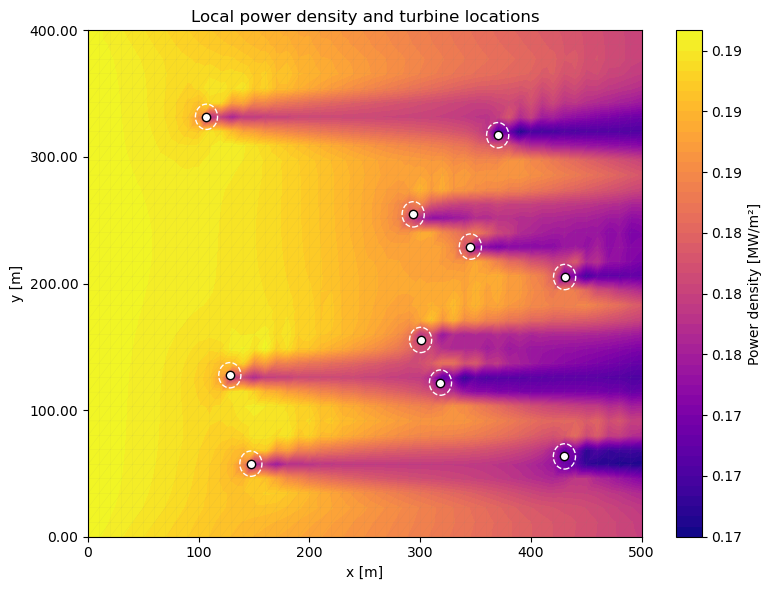

In [11]:
# Solve and get results (this already computes power and velocity)
total_power, velocity = solve_tidal_flow_velocities(
    turbine_positions,
    w,
    W,
    mesh,
    bcs,
    rho,
    depth,
    nu,
    cb,
    g,
    C_T,
    A_T,
    sigma,
)

# Additional turbine analysis (uses the velocity from solver)
turbine_powers, turbine_velocities = compute_turbine_power(
    velocity, turbine_positions, rho, C_T, A_T
)

total_power_check, Max_park_power, _, _ = summarize_turbine_power(
    turbine_powers, turbine_velocities, rho, C_T, A_T, U_inflow, n_turbines
)

print(f" total power (just to check) =", total_power_check)

print("-----------------------------------------")
print(f"Total power: {total_power/1e3:.1f} kW")
print(f"Max park power: {Max_park_power/1e6:.2f} MW")
print(f"Efficiency: {total_power/Max_park_power*100:.1f}%")

# Plots (use w directly - it contains the solved solution)
plot_velocity_field(w, turbine_positions, sigma)
compute_power_field_plot(C_T, rho, A_T, w, turbine_positions, sigma)
